# MNIST dataset pratice

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

## Load dataset and explore

(28, 28, 1) 4


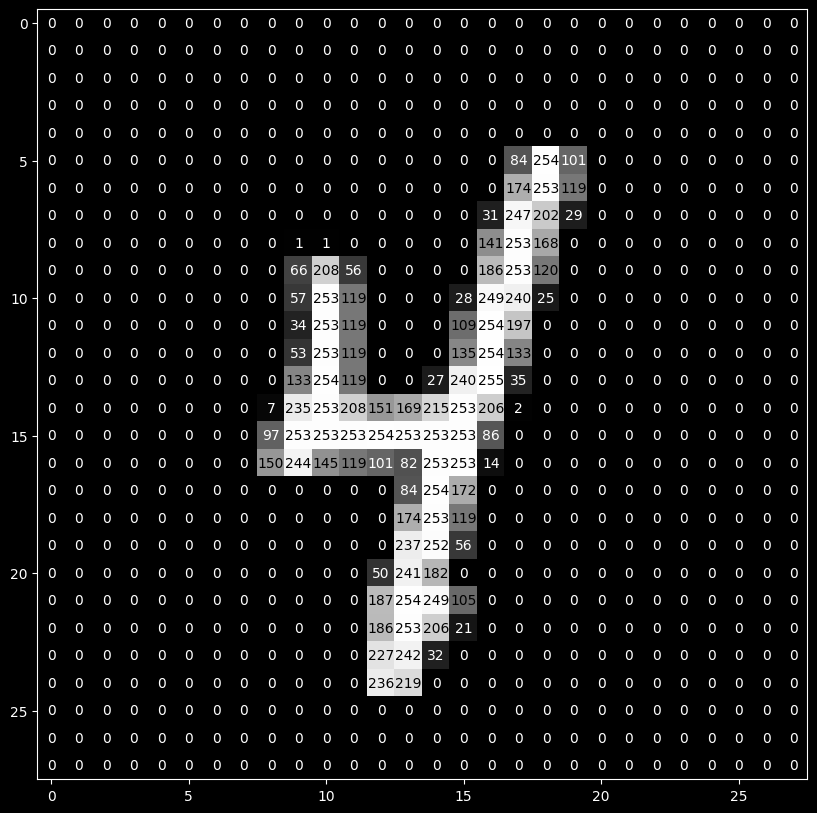

In [67]:
(train_ds, val_ds, test_ds), info = tfds.load('mnist', split=['train[:80%]', 'train[80%:]', 'test'], as_supervised=True, with_info=True)

example = train_ds.take(1)
for data in example:
    img = tfds.as_numpy(data[0])
    label = data[1]
    print(img.shape, tfds.as_numpy(label))
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.imshow(data[0], cmap='gray', vmin=0, vmax=255)
    width, height, _ = img.shape
    tresh = img.max() / 2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(img[x][y][0]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',
                            color='white' if img[x][y][0] < tresh else 'k')



## Prepare data

In [70]:
train_count = 0
val_count = 0
test_count = 0

for data in train_ds:
    train_count += 1

for data in val_ds:
    val_count += 1

for data in test_ds:
    test_count += 1

print("Train samples: ", train_count)
print("Validation samples: ", val_count)
print("Test samples: ", test_count)

Train samples:  48000
Validation samples:  12000
Test samples:  10000


In [71]:
BATCH_SIZE = 20
num_classes = 10

def preprocess(image, label):  # Turn each label value into 1D-arrays with zeros and a one at index=value
    label = tf.one_hot(label, depth=num_classes)
    return image, label

def prepare_dataset(ds, shuffle=False):
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)  # Loads 1000 samples in-memory to be shuffled
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # Fetch batches in the background. Automatically optimizes the number of parallel calls and prefetching

    return ds

train_ds = prepare_dataset(train_ds, shuffle=True)
val_ds = prepare_dataset(val_ds)
test_ds = prepare_dataset(test_ds, shuffle=True)


## Build the DNN

In [80]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(28, 28, 1)))
model.add(tf.keras.layers.Rescaling(1. / 255))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,618 (861.79 KB)

 Trainable params: 220,426 (861.04 KB)

 Non-trainable params: 192 (768.00 B)

## Train the model 

In [81]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="mnist.model.keras", save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

hist = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[checkpointer, early_stopping, lr_scheduler], verbose=2, shuffle=True)

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.08068, saving model to mnist.model.keras
2400/2400 - 54s - 23ms/step - accuracy: 0.9414 - loss: 0.1978 - val_accuracy: 0.9765 - val_loss: 0.0807 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.08068 to 0.05563, saving model to mnist.model.keras
2400/2400 - 56s - 23ms/step - accuracy: 0.9795 - loss: 0.0673 - val_accuracy: 0.9824 - val_loss: 0.0556 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss did not improve from 0.05563
2400/2400 - 50s - 21ms/step - accuracy: 0.9852 - loss: 0.0485 - val_accuracy: 0.9833 - val_loss: 0.0566 - learning_rate: 1.0000e-04
Epoch 4/50

Epoch 4: val_loss improved from 0.05563 to 0.05523, saving model to mnist.model.keras
2400/2400 - 53s - 22ms/step - accuracy: 0.9885 - loss: 0.0383 - val_accuracy: 0.9844 - val_loss: 0.0552 - learning_rate: 1.0000e-04
Epoch 5/50

Epoch 5: val_loss improved from 0.05523 to 0.04937, saving model to mnist.model.keras
2400/2400 - 54s - 22ms/st

## Visualize loss and accuracy

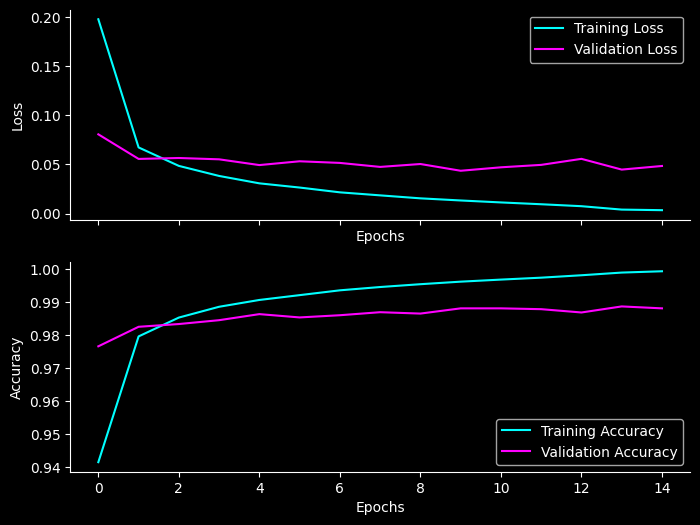

In [82]:
history = hist.history
# plt.style.use('dark_background')
bg_color = '#000000'
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.patch.set_facecolor(bg_color)

ax[0].set_facecolor(bg_color)
ax[0].plot(history['loss'], label='Training Loss', color='cyan')
ax[0].plot(history['val_loss'], label='Validation Loss', color='magenta')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].set_facecolor(bg_color)
ax[1].plot(history['accuracy'], label='Training Accuracy', color='cyan')
ax[1].plot(history['val_accuracy'], label='Validation Accuracy', color='magenta')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

for a in ax:
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)


## Load and evaluate trained model

In [83]:
model = tf.keras.models.load_model('mnist.model.keras')
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

500/500 - 2s - 5ms/step - accuracy: 0.9899 - loss: 0.0343
Test loss: 0.0343
Test accuracy: 0.9899
